<a href="https://colab.research.google.com/github/TheRoberto2512/Morph-Attack-Detection/blob/main/Componente%20Avanzata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size=6>**FACE MORPHING DETECTION: COMPONENTE AVANZATA**</font>
</br><font size=3>*Roberto A. Usai, Davide Senette, Chiara Scalas*</font>



<p><i>“È possibile attaccare un sistema di riconoscimento automatico con i Morph?”</i></p>

<p align="justify">In questo notebook si cerca di trovare una risposta a questa domanda implementando un sistema di riconoscimento facciale <i>naive</i> sfruttando FaceNet. Il sistema viene poi attaccato con successo dalle immagini morph, portando alla costruzione di un modello più robusto in grado di tollerarle. Infine, per attaccare questo nuovo sistema, viene studiata l'efficacia degli attacchi avversari sul modello convolutivo proposto come Classificatore II e integrato nella nuova versione del sistema.</p>

**Indice:**
*   [Import librerie e impostazioni](#1)
*   [Dataset](#2)
*   [Sistema di Riconoscimento Facciale](#3)
*   [Attacco Avversario](#4)
*   [Attacco Avversario con Riconoscimento Facciale](#5)

<a name="1"></a>
# **Import librerie e impostazioni**

In [ ]:
!pip install keras-facenet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 12.0 MB/s eta 0:00:00
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10367 sha256=f0a1cc348a985a4a1abb4fdff87cab30923c87b6b111871279a93e2b2203f4e4
  Stored in directory: /root/.cache/pip/wheels/1d/d8/a9/85cf04ea29321d2afcb82c0caaafdca9195385f9d68cbc7185
Successfully built keras-facenet


In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.model_selection import GridSearchCV
from scipy.spatial.distance import euclidean
from sklearn.metrics import roc_curve, auc
from keras_facenet import FaceNet
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.svm import SVC
from skimage import feature
import tensorflow as tf
from PIL import Image
import numpy as np
import random
import shutil
import joblib
import random
import json
import cv2
import sys
import os

Prima importiamo le librerie, poi montiamo Google Drive per poter accedere facilmente agli altri file.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Path della cartella del progetto su Google Drive:

#@markdown <font color="#ed7d31"><b>Necessario per poter accedere agli altri file</b>!</font>
#@markdown <br>Se la cartella del progetto si trova nella root di Drive, scrivere solo il suo nome:
DRIVE_PATH = "MAD Project" #@param {type:"string"}

DRIVE_PATH = '/content/drive/MyDrive/' + DRIVE_PATH

WEIGHTS_PATH = DRIVE_PATH + '/Weights/'

In [ ]:
sys.path.append(DRIVE_PATH)                       # ci permetterà di importare le funzioni presenti in altri file
from shared_utilities import download_dataset, move_files, split_dataset, get_img_array

Scarichiamo dal file .json gli ID necessari per il download del dataset e del csv.

In [ ]:
with open(DRIVE_PATH + '/settings.json', 'r') as file:
  config = json.load(file)

DATASET_ID = config['DATASET_ID']

In [ ]:
#@title Caricamento di un dataset custom

#@markdown Inserire l'ID del dataset custom. Qualora si volesse usare l'originale, lasciare vuoto.
DATASET_CUSTOM = "1zhWDht4hxcnVu08K6si9RfXZuEfcWxRh" #@param {type:"string"}

if DATASET_CUSTOM != "":
  DATASET_ID = DATASET_CUSTOM

In [ ]:
#@title Impostazioni del Notebook

#@markdown Seme per le funzioni randomiche del notebook:
SEED = 2407 #@param {type:"integer"}

random.seed(SEED)

np.set_printoptions(suppress=True) # NumPy non utilizzerà la notazione scientifica per piccoli numeri, rendendo l'output più leggibile.

<a name="2"></a>
# **Dataset**


## Download

In [ ]:
#@title Impostazioni download

#@markdown Nome del zip dataset post download:
DATASET_NAME = 'AMSL_dataset.zip' #@param {type:"string"}

download_dataset(DATASET_ID, DATASET_NAME, msg=True)

Dopo aver scaricato il dataset lo manipoliamo in modo da unzipparlo, creare le directory per gli split e infine eliminare i file txt e la cartella sample_data creata automaticamente da Colab.

In [ ]:
%%capture
# evita il fastidioso output a video

! unzip "{DATASET_NAME}"                                  # unzippa il file zip
! rm /content/AMSL/*.txt                                  # elimina i file txt
! rm -r /content/sample_data                              # elimina la cartella di default di Colab

if DATASET_CUSTOM == "":                                  # se il dataset è l'originale
  ! mv /content/AMSL/neutral/* /content/AMSL/smiling      # sposta i file della cartella neutral in smiling
  ! mv /content/AMSL/smiling /content/AMSL/bona_fide      # rinomina smiling in bona_fide
  ! rmdir AMSL/neutral                                    # rimuove la cartella neutral (ormai vuota)

## Split

In [ ]:
#@title Parametri dello split
#@markdown Percentuale di split per il test set:
TEST = 20 #@param  {type:"integer"}

#@markdown Percentuale di split per il validation set:
VAL = 20 #@param  {type:"integer"}

path_dataset = '/content/AMSL'

bona_fide_count = len(os.listdir(os.path.join(path_dataset,'bona_fide')))
morphed_count = len(os.listdir(os.path.join(path_dataset,'morphed')))

# path delle cartelle su Colab
test = '/content/Dataset/test/'
val = '/content/Dataset/val/'
train = '/content/Dataset/train/'

split_dataset(path_dataset=path_dataset, train=train, val=val, test=test, bona_fide_count=bona_fide_count, morphed_count=morphed_count, VAL=VAL, TEST=TEST)

In [ ]:
print("Immagini di test:\n-Bona Fide:\t%d\n-Morphed:\t%d\n" % (len(os.listdir('/content/Dataset/test/bona_fide')), len(os.listdir('/content/Dataset/test/morphed'))) )

print("Immagini di train:\n-Bona Fide:\t%d\n-Morphed:\t%d\n" % (len(os.listdir('/content/Dataset/train/bona_fide')), len(os.listdir('/content/Dataset/train/morphed'))) )

print("Immagini di val:\n-Bona Fide:\t%d\n-Morphed:\t%d\n" % (len(os.listdir('/content/Dataset/val/bona_fide')), len(os.listdir('/content/Dataset/val/morphed'))) )

Immagini di test:
-Bona Fide:	245
-Morphed:	265

Immagini di train:
-Bona Fide:	734
-Morphed:	796

Immagini di val:
-Bona Fide:	245
-Morphed:	265



## Caricamento

In [ ]:
#@title Parametri del dataset

#@markdown Dimensione del batch di addestramento:
BATCH_SIZE = 32 #@param {type:"integer"}

# estrae automaticamente le dimensioni delle immagini
folder_path = '/content/Dataset/test/bona_fide' ; image_files = [f for f in os.listdir(folder_path)]

if image_files:
  with Image.open(os.path.join(folder_path, image_files[0])) as img: # carica la prima immagine per ottenere le dimensioni
    width, height = img.size
    IMAGE_SIZE = (width, height)
    IMAGE_WIDTH, IMAGE_HEIGHT = width, height
    IMAGE_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(
    directory = '/content/Dataset/train',
    labels = 'inferred',
    label_mode = 'binary',
    color_mode = 'rgb',
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    seed = SEED,
    shuffle = True,
)

val_data = tf.keras.utils.image_dataset_from_directory(
    directory = '/content/Dataset/val',
    labels='inferred',
    label_mode = 'binary',
    color_mode = 'rgb',
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    seed = SEED,
    shuffle = True,
)

test_data = tf.keras.utils.image_dataset_from_directory(
    directory = '/content/Dataset/test',
    labels = 'inferred',
    label_mode = 'binary',
    color_mode = 'rgb',
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    seed = SEED,
    shuffle = True,
)

class_names = train_data.class_names

Found 1530 files belonging to 2 classes.
Found 510 files belonging to 2 classes.
Found 510 files belonging to 2 classes.


<a name="3"></a>
# **Sistema di riconoscimento facciale**

In [ ]:
# -- -- # -- -- # -- -- # -- -- # -- -- # -- -- # -- -- #

embedder = FaceNet() # inizializzazione del modello FaceNet

# -- -- # -- -- # -- -- # -- -- # -- -- # -- -- # -- -- #

def load_image(image_path):
  '''
  Funzione per caricare un'immagine.

  Parametri:
  - image_path: percorso dell'immagine.

  Restituisce:
  - l'immagine caricata come ndarray.
  '''

  img = cv2.imread(image_path)                                            # legge l'immagine

  if img is None:                                                         # se l'immagine non è stata caricata correttamente
    raise ValueError(f"Impossibile caricare l'immagine da {image_path}")  # stampa un errore

  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)                              # converte l'immagine da BGR a RGB

  img = np.expand_dims(img, axis=0).astype('float32')                     # aggiunge una dimensione per il batch

  return img

# -- -- # -- -- # -- -- # -- -- # -- -- # -- -- # -- -- #

def get_embeddings_by_path(image_paths):
  '''
  Funzione per estrarre le embedding di un insieme di immagini.

  Parametri:
  - image_paths: lista di percorsi delle immagini.
  '''

  embeddings = []                                                                 # lista per le embedding

  for image_path in image_paths:                                                  # per ogni immagine
    try:                                                                          # prova
      img = load_image(image_path)                                                # carica l'immagine
      embedding = embedder.embeddings(img)                                        # estrae l'embedding
      embeddings.append(embedding[0])                                             # aggiunge l'embedding alla lista
    except ValueError as e:                                                       # altrimenti
      print(e)                                                                    # stampa l'errore

  return embeddings

# -- -- # -- -- # -- -- # -- -- # -- -- # -- -- # -- -- #

def get_all_image_paths(folder_path):
  '''
  Funzione per ottenere tutte le immagini in una cartella.

  Parametri:
  - folder_path: percorso della cartella.

  Restituisce:
  - una lista di percorsi delle immagini.
  '''

  return [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg')]

# -- -- # -- -- # -- -- # -- -- # -- -- # -- -- # -- -- #

def compute_distances(persona_path, bona_fide_path):
  '''
  Funzione principale per determinare la soglia ottimale.

  Parametri:
  - persona_path: percorso della cartella delle immagini della persona.
  - bona_fide_path: percorso della cartella delle immagini dei soggetti diversi.
  '''
  # Salva il riferimento originale a stdout
  original_stdout = sys.stdout

  try:
      # Reindirizza stdout a /dev/null
      sys.stdout = open(os.devnull, 'w')

      # carica le immagini della persona da identificare
      persona_image_paths = get_all_image_paths(persona_path)
      persona_embeddings = get_embeddings_by_path(persona_image_paths)

      # carica le immagini dei soggetti diversi
      bona_fide_image_paths = get_all_image_paths(bona_fide_path)
      bona_fide_embeddings = get_embeddings_by_path(bona_fide_image_paths)

      # calcolo delle distanze tra le immagini della persona scelta
      positive_distances = []
      for i in range(len(persona_embeddings)):
          for j in range(i + 1, len(persona_embeddings)):
              distance = euclidean(persona_embeddings[i], persona_embeddings[j])
              positive_distances.append(distance)

      # calcolo delle distanze tra le immagini della persona scelta e gli altri soggetti
      negative_distances = []
      for persona_embedding in persona_embeddings:
          for bona_fide_embedding in bona_fide_embeddings:
              distance = euclidean(persona_embedding, bona_fide_embedding)
              negative_distances.append(distance)

  finally:
      # Ripristina stdout
      sys.stdout.close()
      sys.stdout = original_stdout


  return positive_distances, negative_distances

# -- -- # -- -- # -- -- # -- -- # -- -- # -- -- # -- -- #

def make_identity(person_ID):
  '''
  Funzione per creare una cartella contenente tutte le immagini bona_fide relative alla persona corrispondente al person_ID fornito.

  Parametri:
  - person_ID: ID della persona per la quale si vogliono le immagini.

  Restituisce:
  - il percorso della cartella generata.
  '''

  all_people = '/content/all_people/'                                               # cartella generale con tutte le identità

  if not os.path.exists(all_people):                                                # se la cartella generale non esiste
    os.makedirs(all_people)                                                         # crea la cartella generale

  person_folder = '/content/all_people/person_' + str(person_ID)

  if not os.path.exists(person_folder):                                             # se la cartella dell'indivuduo non esiste
    os.makedirs(person_folder)                                                      # crea la cartella
    for dirs in os.listdir('/content/Dataset/'):                                    # per ogni cartella (test, train, val)
      for file in os.listdir('/content/Dataset/' + dirs + '/bona_fide/'):           # per ogni file nella cartella bona_fide
        if person_ID in file:                                                       # se il person_ID è presente nel nome del file
          shutil.copy('/content/Dataset/' + dirs + '/bona_fide/' + file, person_folder)
    return person_folder                                                            # restituisce il percorso della cartella
  else:
    raise ValueError(f"La cartella {person_folder} esiste già.")                    # altrimenti stampa un errore

# -- -- # -- -- # -- -- # -- -- # -- -- # -- -- # -- -- #

def everyone_except_one(person_ID):
  '''
  Funzione per creare una cartella contenente tutte le immagini bona_fide ECCETTO quelle della persona corrispondente al person_ID fornito.

  Parametri:
  - person_ID: ID della persona per la quale si vogliono le immagini.

  Restituisce:
  - il percorso della cartella generata.
  '''

  excluded = '/content/excluded/'                                                 # cartella generale

  if not os.path.exists(excluded):                                                # se la cartella generale non esiste
    os.makedirs(excluded)

  person_excluded = '/content/excluded/not_person_' + str(person_ID)

  if not os.path.exists(person_excluded):                                         # se la cartella dell'indivuduo non esiste
    os.makedirs(person_excluded)
    for dirs in os.listdir('/content/Dataset/'):                                  # per ogni cartella (test, train, val)
      for file in os.listdir('/content/Dataset/' + dirs + '/bona_fide/'):         # per ogni file nella cartella bona_fide
        if person_ID not in file:                                                 # se il person_ID è presente nel nome del file
          shutil.copy('/content/Dataset/' + dirs + '/bona_fide/' + file, person_excluded)
    return person_excluded                                                        # restituisce il percorso della cartella
  else:
    raise ValueError(f"La cartella {person_excluded} esiste già.")                # altrimenti stampa un errore

# -- -- # -- -- # -- -- # -- -- # -- -- # -- -- # -- -- #

def make_morphed_identity(person_ID):
  '''
  Funzione per ottenere le immagini morph a cui ha preso parte la persona corrispondente al person_ID fornito.

  Parametri:
  - person_ID: ID della persona per la quale si vogliono le immagini.

  Restituisce:
  - il percorso della cartella generata.
  '''

  morphed_identities = '/content/morphed_identities/'

  if not os.path.exists(morphed_identities):                                      # se la cartella generale non esiste
    os.makedirs(morphed_identities)

  morphed_identity = '/content/morphed_identities/person_' + str(person_ID)

  if not os.path.exists(morphed_identity):                                        # se la cartella dell'indivuduo non esiste
    os.makedirs(morphed_identity)
    for dirs in os.listdir('/content/Dataset/'):                                  # per ogni cartella (test, train, val)
      for file in os.listdir('/content/Dataset/' + dirs + '/morphed/'):           # per ogni file nella cartella bona_fide
        if person_ID in file:                                                     # se il person_ID è presente nel nome del file
          shutil.copy('/content/Dataset/' + dirs + '/morphed/' + file, morphed_identity)
    return morphed_identity
  else:
    raise ValueError(f"La cartella {morphed_identity} esiste già.")               # altrimenti stampa un errore

# -- -- # -- -- # -- -- # -- -- # -- -- # -- -- # -- -- #

def determine_optimal_thresholds(positive_distances, negative_distances):
  '''
  Funzione per determinare la soglia ottimale utilizzando vari metodi.

  Parametri:
  - positive_distances: distanze tra immagini della persona scelta.
  - negative_distances: distanze tra immagini della persona scelta e gli altri soggetti.
  '''

  # metodo 1: media tra la distanza massima positiva e la distanza minima negativa
  max_positive_distance = max(positive_distances)
  min_negative_distance = min(negative_distances)
  threshold_mean = (max_positive_distance + min_negative_distance) / 2

  # creazione di etichette e distanze per calcoli successivi
  distances = positive_distances + negative_distances
  labels = [1] * len(positive_distances) + [0] * len(negative_distances)
  _, _, thresholds = roc_curve(labels, distances) # calcolo le thresholds

  # metodo 2: massimizzazione del F1 Score
  f1_scores = [f1_score(labels, [1 if d <= t else 0 for d in distances]) for t in thresholds]
  optimal_idx_f1 = np.argmax(f1_scores)
  threshold_f1 = thresholds[optimal_idx_f1]

  # metodo 3: massimizzazione dell'accuratezza
  accuracies = [accuracy_score(labels, [1 if d <= t else 0 for d in distances]) for t in thresholds]
  optimal_idx_acc = np.argmax(accuracies)
  threshold_acc = thresholds[optimal_idx_acc]

  # metodo 4: media delle precedenti
  Mean_Threshold = (threshold_mean + threshold_f1 + threshold_acc)/3

  # Stampa delle soglie calcolate
  print(f'Soglia metodo della media: {threshold_mean}')
  print(f'Soglia metodo F1 Score: {threshold_f1}')
  print(f'Soglia metodo Accuratezza: {threshold_acc}')
  print(f'Soglia Media Threshold: {Mean_Threshold}')

  return threshold_mean, threshold_f1, threshold_acc, Mean_Threshold

# -- -- # -- -- # -- -- # -- -- # -- -- # -- -- # -- -- #

def verify_access(persona_embeddings, morph_embeddings, threshold):
  '''
  Funzione per verificare l'accesso basato sulle immagini morph.

  Parametri:
  - persona_embeddings: embedding delle immagini della persona.
  - morph_embeddings: embedding delle immagini morph.
  - threshold: soglia di distanza per l'accesso.
  '''

  passed, blocked = 0, 0

  for i, morph_embedding in enumerate(morph_embeddings):
    morph_embedding = np.squeeze(morph_embedding)
    distances = [euclidean(morph_embedding, persona_embedding) for persona_embedding in persona_embeddings]
    min_distance = min(distances)

    if min_distance <= threshold:
      print(f'Morph {i+1:02d}: accesso CONSENTITO\t(Distanza minima: {min_distance:.3f})')
      passed += 1
    else:
      print(f'Morph {i+1:02d}: accesso NEGATO\t(Distanza minima: {min_distance:.3f})')
      blocked += 1

  print("- - - - - - - - - - - - - - - - - - - - - - - - - - - -")
  print(f'Accessi consentiti: {passed}/{len(morph_embeddings)}')
  print(f'Accessi bloccati: {blocked}/{len(morph_embeddings)}')
  print("- - - - - - - - - - - - - - - - - - - - - - - - - - - -")

# -- -- # -- -- # -- -- # -- -- # -- -- # -- -- # -- -- #

def verify_access_with_MAD(persona_embeddings, morph_path, morph_image_paths, threshold, model):
  '''
  Funzione per verificare l'accesso delle immagini morph.

  Parametri:
  - persona_embeddings: embedding delle immagini della persona.
  - morph_embeddings: embedding delle immagini morph.
  - threshold: soglia di distanza per l'accesso.
  - model: modello di classificazione addestrato per rilevare il morphing.
  '''

  passed, blocked = 0, 0

  for i, morph_embedding in enumerate(morph_embeddings):
    morph_embedding = np.squeeze(morph_embedding)
    distances = [euclidean(morph_embedding, persona_embedding) for persona_embedding in persona_embeddings]
    min_distance = min(distances)
    img = load_image(morph_image_paths[i])

    prob = model.predict(img, verbose=0)
    if min_distance <= threshold and prob[0][0] < 0.5:
      print(f'Morph {i+1:02d}: accesso CONSENTITO\t(Distanza minima: {min_distance:.3f})')
      passed += 1
    else:
      print(f'Morph {i+1:02d}: accesso NEGATO\t(Distanza minima: {min_distance:.3f})')
      blocked += 1

  print("- - - - - - - - - - - - - - - - - - - - - - - - - - - -")
  print(f'Accessi consentiti: {passed}/{len(morph_embeddings)}')
  print(f'Accessi bloccati: {blocked}/{len(morph_embeddings)}')
  print("- - - - - - - - - - - - - - - - - - - - - - - - - - - -")

# -- -- # -- -- # -- -- # -- -- # -- -- # -- -- # -- -- #

In [ ]:
#@title Scegliere l'identità di una persona

#@markdown È necessaria una stringa contenente l'ID (es: 021):
person_ID = "001" #@param {type:"string"}

persona_path = make_identity(person_ID)                  # genera la cartella contenente solo foto bona_fide dell'identità scelta
excluded_person_path = everyone_except_one(person_ID)    # genera la cartella contenente tutte le foto bona_fide tranne quelle dell'identità scelta
morphed_identity_path = make_morphed_identity(person_ID) # genera la cartella contenente tutte le foto morphed a cui ha preso parte l'identità scelta

ValueError: La cartella /content/all_people/person_001 esiste già.

In [ ]:
%%capture
# evita il fastidioso output a video

positive_distances, negative_distances = compute_distances(persona_path, excluded_person_path)

Soglia metodo della media: 0.6937013268470764
Soglia metodo F1 Score: 0.9966468214988708
Soglia metodo Accuratezza: 0.9966468214988708
Soglia Media Threshold: 0.8956649899482727


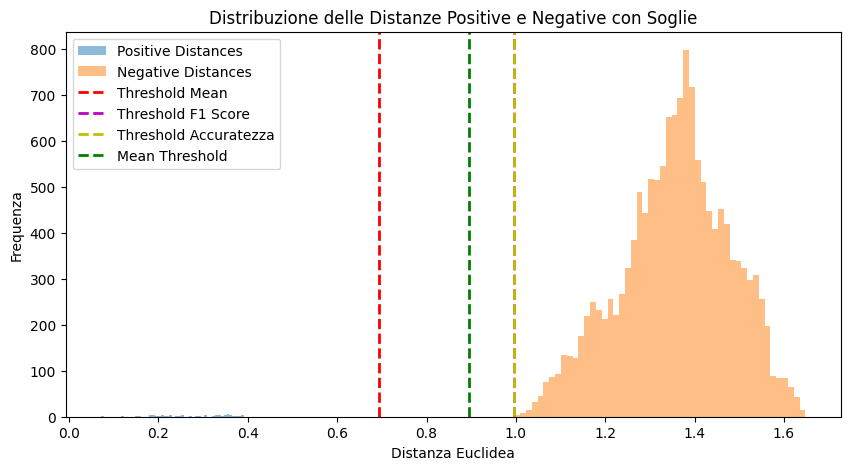

In [ ]:
# determina le soglie ottimali utilizzando vari metodi
threshold_mean, threshold_f1, threshold_acc, Mean_Threshold = determine_optimal_thresholds(positive_distances, negative_distances)

# visualizzazione dell'istogramma delle distanze con soglie
plt.figure(figsize=(10, 5))
plt.hist(positive_distances, bins=50, alpha=0.5, label='Positive Distances')
plt.hist(negative_distances, bins=50, alpha=0.5, label='Negative Distances')
plt.axvline(threshold_mean, color='r', linestyle='dashed', linewidth=2, label='Threshold Mean')
plt.axvline(threshold_f1, color='m', linestyle='dashed', linewidth=2, label='Threshold F1 Score')
plt.axvline(threshold_acc, color='y', linestyle='dashed', linewidth=2, label='Threshold Accuratezza')
plt.axvline(Mean_Threshold, color='g', linestyle='dashed', linewidth=2, label='Mean Threshold')
plt.xlabel('Distanza Euclidea')
plt.ylabel('Frequenza')
plt.legend(loc='upper left')
plt.title('Distribuzione delle Distanze Positive e Negative con Soglie')
plt.show()

In [ ]:
%%capture
# evita il fastidioso output a video

persona_image_paths = get_all_image_paths(persona_path)         # carica le immagini della persona
persona_embeddings = get_embeddings_by_path(persona_image_paths)        # calcola gli embeddings

morph_image_paths = get_all_image_paths(morphed_identity_path)  # carica le immagini morph a cui ha preso parte la persona
morph_embeddings = get_embeddings_by_path(morph_image_paths)            # calcola gli embeddings

In [ ]:
verify_access(persona_embeddings, morph_embeddings, Mean_Threshold)

Morph 01: accesso NEGATO	(Distanza minima: 1.012)
Morph 02: accesso CONSENTITO	(Distanza minima: 0.799)
Morph 03: accesso CONSENTITO	(Distanza minima: 0.722)
Morph 04: accesso CONSENTITO	(Distanza minima: 0.815)
Morph 05: accesso CONSENTITO	(Distanza minima: 0.825)
Morph 06: accesso CONSENTITO	(Distanza minima: 0.840)
Morph 07: accesso CONSENTITO	(Distanza minima: 0.886)
Morph 08: accesso CONSENTITO	(Distanza minima: 0.841)
Morph 09: accesso CONSENTITO	(Distanza minima: 0.825)
Morph 10: accesso CONSENTITO	(Distanza minima: 0.697)
Morph 11: accesso CONSENTITO	(Distanza minima: 0.775)
Morph 12: accesso CONSENTITO	(Distanza minima: 0.713)
Morph 13: accesso CONSENTITO	(Distanza minima: 0.736)
Morph 14: accesso NEGATO	(Distanza minima: 0.923)
Morph 15: accesso CONSENTITO	(Distanza minima: 0.666)
Morph 16: accesso NEGATO	(Distanza minima: 1.030)
Morph 17: accesso CONSENTITO	(Distanza minima: 0.846)
Morph 18: accesso NEGATO	(Distanza minima: 0.945)
Morph 19: accesso CONSENTITO	(Distanza minim

In [ ]:
verify_access(persona_embeddings, morph_embeddings, threshold_mean)

Morph 01: accesso NEGATO	(Distanza minima: 1.012)
Morph 02: accesso NEGATO	(Distanza minima: 0.799)
Morph 03: accesso NEGATO	(Distanza minima: 0.722)
Morph 04: accesso NEGATO	(Distanza minima: 0.815)
Morph 05: accesso NEGATO	(Distanza minima: 0.825)
Morph 06: accesso NEGATO	(Distanza minima: 0.840)
Morph 07: accesso NEGATO	(Distanza minima: 0.886)
Morph 08: accesso NEGATO	(Distanza minima: 0.841)
Morph 09: accesso NEGATO	(Distanza minima: 0.825)
Morph 10: accesso NEGATO	(Distanza minima: 0.697)
Morph 11: accesso NEGATO	(Distanza minima: 0.775)
Morph 12: accesso NEGATO	(Distanza minima: 0.713)
Morph 13: accesso NEGATO	(Distanza minima: 0.736)
Morph 14: accesso NEGATO	(Distanza minima: 0.923)
Morph 15: accesso CONSENTITO	(Distanza minima: 0.666)
Morph 16: accesso NEGATO	(Distanza minima: 1.030)
Morph 17: accesso NEGATO	(Distanza minima: 0.846)
Morph 18: accesso NEGATO	(Distanza minima: 0.945)
Morph 19: accesso NEGATO	(Distanza minima: 0.701)
Morph 20: accesso NEGATO	(Distanza minima: 0.7

Prima carichiamo l'EfficentNetV2-S salvato su Drive.<br>
<font color="#ed7d31"><b>È necessario avere un modello salvato!</b></font>

In [ ]:
shutil.copy('/content/drive/MyDrive/MAD Project/Models/EfficientNetV2SFT.keras', '/content/EfficientNetV2SFT.keras')
model = tf.keras.models.load_model('/content/EfficientNetV2SFT.keras')

In [ ]:
verify_access_with_MAD(persona_embeddings, morph_embeddings,morph_image_paths, threshold_mean, model)

Morph 01: accesso NEGATO	(Distanza minima: 1.012)
Morph 02: accesso NEGATO	(Distanza minima: 0.799)
Morph 03: accesso NEGATO	(Distanza minima: 0.722)
Morph 04: accesso NEGATO	(Distanza minima: 0.815)
Morph 05: accesso NEGATO	(Distanza minima: 0.825)
Morph 06: accesso NEGATO	(Distanza minima: 0.840)
Morph 07: accesso NEGATO	(Distanza minima: 0.886)
Morph 08: accesso NEGATO	(Distanza minima: 0.841)
Morph 09: accesso NEGATO	(Distanza minima: 0.825)
Morph 10: accesso NEGATO	(Distanza minima: 0.697)
Morph 11: accesso NEGATO	(Distanza minima: 0.775)
Morph 12: accesso NEGATO	(Distanza minima: 0.713)
Morph 13: accesso NEGATO	(Distanza minima: 0.736)
Morph 14: accesso NEGATO	(Distanza minima: 0.923)
Morph 15: accesso NEGATO	(Distanza minima: 0.666)
Morph 16: accesso NEGATO	(Distanza minima: 1.030)
Morph 17: accesso NEGATO	(Distanza minima: 0.846)
Morph 18: accesso NEGATO	(Distanza minima: 0.945)
Morph 19: accesso NEGATO	(Distanza minima: 0.701)
Morph 20: accesso NEGATO	(Distanza minima: 0.719)


<a name="4"></a>
# **Attacco Avversario**

Prima carichiamo l'EfficentNetV2-S salvato su Drive.<br>
<font color="#ed7d31"><b>È necessario avere un modello salvato!</b></font>

In [ ]:
shutil.copy('/content/drive/MyDrive/MAD Project/Models/EfficientNetV2SFT.keras', '/content/EfficientNetV2SFT.keras')
model = tf.keras.models.load_model('/content/EfficientNetV2SFT.keras')

Le seguenti funzioni permetteranno la corretta esecuzione della generazione di immagini perturbate per effettuare gli attacchi avversari.

In [ ]:
# -- -- # -- -- # -- -- # -- -- # -- -- # -- -- # -- -- #

loss_object = tf.keras.losses.BinaryCrossentropy() # definisce la funzione di perdita

# -- -- # -- -- # -- -- # -- -- # -- -- # -- -- # -- -- #

def transform_to_tensor(image, original_label):
  '''
  Funzione per trasformare immagine e label in tensori.

  Parametri:
  - image: immagine ottenuta con get_img_array().
  - original_label: 1 se l'immagine è morphed, 0 se l'immagine è bona_fide.
  '''

  img_tensor = image / 255.0                    # rescaling dei valor
  img_tensor = tf.convert_to_tensor(img_tensor) # conversione in tensori

  label = tf.one_hot([int(original_label)], 2)  # 2 perché è il numero di classi
  label = tf.squeeze(label)                     # rimozione della dimensione

  return img_tensor, label

# -- -- # -- -- # -- -- # -- -- # -- -- # -- -- # -- -- #

def create_adversarial_pattern(input_image, input_label, debug_print=False):
  '''
  Funzione per creare il pattern per l'attacco avversario.

  Parametri:
  - input_image: immagine ottenuta con transform_to_tensor().
  - input_label: label ottenuta con transform_to_tensor().
  - debug_print: se True, stampa i valori di debug (default = False).
  '''

  with tf.GradientTape() as tape:
    tape.watch(input_image)                       # osserva il gradiente dell'immagine
    prediction = model(input_image)               # predizione del modello
    loss = loss_object(input_label, prediction)   # calcola la loss

    if debug_print:
      print("Loss:", loss.numpy())                # stampa la loss

  gradient = tape.gradient(loss, input_image)     # calcola il gradiente

  if debug_print:
    if gradient is None:
      print("Gradient is None, check the model and loss function.")
      return None
    else:
      print("Gradient shape:", gradient.shape)
      print("Gradient min:", tf.reduce_min(gradient).numpy())
      print("Gradient max:", tf.reduce_max(gradient).numpy())

  signed_grad = tf.sign(gradient)                 # calcola il segno del gradiente
  return signed_grad

# -- -- # -- -- # -- -- # -- -- # -- -- # -- -- # -- -- #

def display_images(imageOriginal, image_adv, confidence_original=-1, confidence_adv=-1):
  '''
  Funzione per visualizzare l'immagine originale e l'immagine perturbata.

  Parametri:
  - imageOriginal: immagine originale.
  - image_adv: immagine perturbata.
  - confidence_original: confidenza dell'immagine originale.
  - confidence_adv: confidenza dell'immagine perturbata.
  '''

  imageOriginal = np.squeeze(imageOriginal) # sistema la shape rimuovendo la dimensione legata al batch
  image_adv = np.squeeze(image_adv)         # sistema la shape rimuovendo la dimensione legata al batch

  fig, ax = plt.subplots(1, 2, figsize=(10, 5))

  ax[0].imshow(imageOriginal)
  ax[0].set_title('Immagine originale', fontweight='bold')
  ax[0].axis('off')

  if confidence_original != -1:
    ax[0].text(0.5, -0.05, f"Probabilità Morph: {confidence_original:.2f}%", size=12, ha='center', transform=ax[0].transAxes)

  ax[1].imshow(image_adv)
  ax[1].set_title('Immagine perturbata', fontweight='bold')
  ax[1].axis('off')

  if confidence_adv != -1:
    ax[1].text(0.5, -0.05, f"Probabilità Morph: {confidence_adv:.2f}%", size=12, ha='center', transform=ax[1].transAxes)

  plt.tight_layout()
  plt.show()

# -- -- # -- -- # -- -- # -- -- # -- -- # -- -- # -- -- #

Predizione immagine originale:	100.00000% morphed
Predizione immagine perturbata:	0.56506% morphed


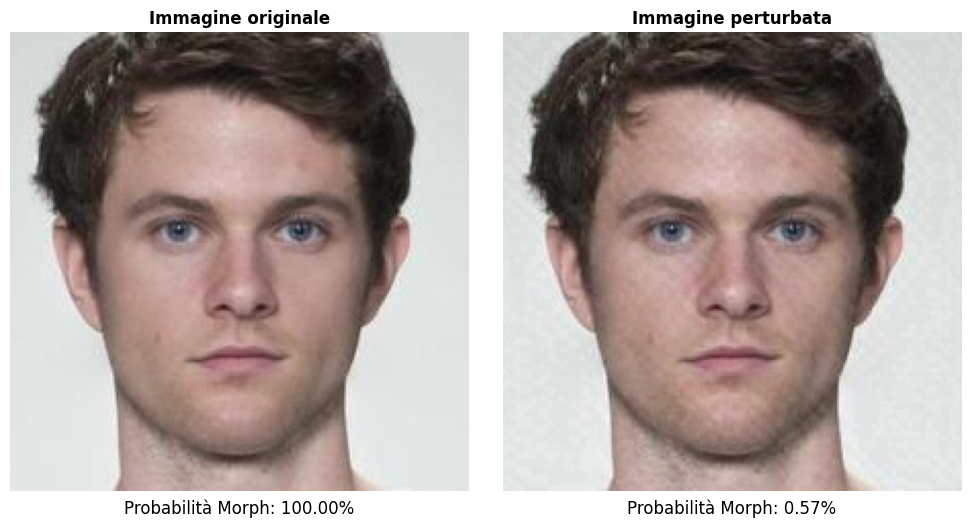

In [ ]:
#@title Dimostrazione con perturbazione di una singola immagine

#@markdown Inserire il percorso dell'immagine <code>morphed</code>:
original_img_path = '/content/Dataset/test/morphed/104_03_012_03_alpha0.5_combined_morph_q56.jpg' #@param {type:"string"}

#@markdown Parametro epsilon per regolare l'intensità della perturbazione:
epsilon = 0.01 #@param {type:"number"}

#@markdown Se <code>True</code>, visualizza dettagliatamente le predizioni del modello prima e dopo la perturbazione:
print_preds = True #@param {type:"boolean"}

#@markdown Se <code>True</code>, stampa l'immagine originale e l'immagine perturbata per confrontarle:
print_images = True #@param {type:"boolean"}

#@markdown Impostazioni per la barra di caricamento del modello in fase di predizione:
#@markdown <br> - <code>0</code> : nessun output
#@markdown <br> - <code>1</code> : barra di progresso
model_verbose = 0 #@param [0, 1]

# -- -- # -- -- # -- -- # -- -- # -- -- # -- -- # -- -- #

img_original = get_img_array(original_img_path, target_size=IMAGE_SIZE)           # si carica l'immagine originale
original_probs = model.predict(img_original, verbose=int(model_verbose))          # si ottengono le sue predizioni

img_tensor, label = transform_to_tensor(img_original, 1)                          # si trasforma in tensori (1 perché l'immagine è morphed)
perturbations = create_adversarial_pattern(img_tensor, label)                     # si crea il pattern

adv_x = img_tensor + epsilon * perturbations                                      # si applica la perturbazione
adv_x = tf.clip_by_value(adv_x, -1, 1)                                            # si riporta all'intervallo [-1, 1]

adv_probs = model.predict(adv_x, verbose=int(model_verbose))                      # si ottengono le predizioni dell'immagine perturbata

if print_preds:
  print("Predizione immagine originale:\t%.5f%% morphed" % (original_probs[0][0]*100) )
  print("Predizione immagine perturbata:\t%.5f%% morphed" % (adv_probs[0][0]*100) )

if print_images:
  display_images(img_original / 255.0, adv_x, confidence_original=(original_probs[0][0]*100), confidence_adv=(adv_probs[0][0]*100))

<a name="5"></a>
# **Attacco Avversario al Sistema di Riconoscimento Facciale**

In [ ]:
#@title Scegliere l'identità di una persona
!rm -r '/content/excluded'
!rm -r '/content/all_people'
!rm -r '/content/morphed_identities'

#@markdown È necessaria una stringa contenente l'ID (es: 021):
person_ID = "001" #@param {type:"string"}

persona_path = make_identity(person_ID)                  # genera la cartella contenente solo foto bona_fide dell'identità scelta
excluded_person_path = everyone_except_one(person_ID)    # genera la cartella contenente tutte le foto bona_fide tranne quelle dell'identità scelta
morphed_identity_path = make_morphed_identity(person_ID) # genera la cartella contenente tutte le foto morphed a cui ha preso parte l'identità scelta

In [ ]:
adv_images = []                                                                         # per contenere le immagini perturbate

for imgs_path in os.listdir('/content/morphed_identities/person_' + person_ID):         # per ogni immagine morph della persona
  complete_path = '/content/morphed_identities/person_' + person_ID + '/' + imgs_path   # path completo

  img = get_img_array(complete_path, target_size=IMAGE_SIZE)                            # si prende l'immagine
  img_tensor, label = transform_to_tensor(img, 1)                                       # si trasforma in tensori (1 perché l'immagine è morphed)

  perturbations = create_adversarial_pattern(img_tensor, label)                         # si crea il pattern

  adv_x = img_tensor + epsilon * perturbations                                          # si applica la perturbazione
  adv_x = tf.clip_by_value(adv_x, -1, 1)                                                # si clippano i valori

  adv_images.append(adv_x)                                                              # si aggiunge l'immagine perturbata alla lista

In [ ]:
def extract_embeddings(face_net, image_tensor):
    # converte il tensore in array numpy
    image_array = image_tensor.numpy()
    # rimuove la dimensione batch se presente
    if image_array.shape[0] == 1:
        image_array = np.squeeze(image_array, axis=0)

    # debug: stampa la forma dell'immagine dopo aver rimosso la dimensione batch
    print("Forma dell'immagine senza batch:", image_array.shape)

    # assicurati che l'immagine abbia 3 canali
    if image_array.shape[-1] != 3:
        image_array = np.squeeze(image_array, axis=-1)
        image_array = np.stack((image_array,)*3, axis=-1)

    # debug: stampa la forma dell'immagine
    print("Forma dell'immagine:", image_array.shape)

    # ottieni la dimensione richiesta dal modello FaceNet
    s = face_net.metadata.get('image_size', 224)

    # debug: stampa la dimensione s
    print("Dimensione dell'immagine s:", s)

    # ridimensiona l'immagine per essere compatibile con FaceNet
    if isinstance(s, int) and image_array.size > 0:
        resized_image = cv2.resize(image_array, (s, s))
    else:
        raise ValueError("La dimensione dell'immagine non è correttamente definita o l'immagine è vuota.")

    # normalizza l'immagine
    normalized_image = face_net._normalize(resized_image)
    # estrai l'embedding
    embedding = face_net.model.predict(np.expand_dims(normalized_image, axis=0))
    return embedding

# -- -- # -- -- # -- -- # -- -- # -- -- # -- -- # -- -- #

def verify_access_with_MAD(persona_embeddings, morph_embeddings, threshold, model):
  '''
  Funzione per verificare l'accesso delle immagini morph.

  Parametri:
  - persona_embeddings: embedding delle immagini della persona.
  - morph_embeddings: embedding delle immagini morph.
  - threshold: soglia di distanza per l'accesso.
  - model: modello di classificazione addestrato per rilevare il morphing.
  '''

  passed, blocked = 0, 0

  for i, morph_embedding in enumerate(morph_embeddings):
    morph_embedding = np.squeeze(morph_embedding)
    distances = [euclidean(morph_embedding, persona_embedding) for persona_embedding in persona_embeddings]
    min_distance = min(distances)

    prob = model.predict(img, verbose=0)
    if min_distance <= threshold and prob[0][0] < 0.5:
      print(f'Morph {i+1:02d}: accesso CONSENTITO\t(Distanza minima: {min_distance:.3f})')
      passed += 1
    else:
      print(f'Morph {i+1:02d}: accesso NEGATO\t(Distanza minima: {min_distance:.3f})')
      blocked += 1

  print("- - - - - - - - - - - - - - - - - - - - - - - - - - - -")
  print(f'Accessi consentiti: {passed}/{len(morph_embeddings)}')
  print(f'Accessi bloccati: {blocked}/{len(morph_embeddings)}')
  print("- - - - - - - - - - - - - - - - - - - - - - - - - - - -")

Infine si calcolano gli embeddings di tutte le immagini perturbate e si può procedere con gli attacchi.

In [ ]:
morph_adv_embeddings = []

for adv in adv_images:
  emb = extract_embeddings(embedder, adv)
  morph_adv_embeddings.append(emb)

Test di accesso senza MAD:

In [ ]:
verify_access(persona_embeddings, morph_adv_embeddings, threshold_mean)

Morph 01: accesso NEGATO	(Distanza minima: 1.373)
Morph 02: accesso NEGATO	(Distanza minima: 1.373)
Morph 03: accesso NEGATO	(Distanza minima: 1.373)
Morph 04: accesso NEGATO	(Distanza minima: 1.373)
Morph 05: accesso NEGATO	(Distanza minima: 1.373)
Morph 06: accesso NEGATO	(Distanza minima: 1.373)
Morph 07: accesso NEGATO	(Distanza minima: 1.373)
Morph 08: accesso NEGATO	(Distanza minima: 1.373)
Morph 09: accesso NEGATO	(Distanza minima: 1.373)
Morph 10: accesso NEGATO	(Distanza minima: 1.373)
Morph 11: accesso NEGATO	(Distanza minima: 1.373)
Morph 12: accesso NEGATO	(Distanza minima: 1.373)
Morph 13: accesso NEGATO	(Distanza minima: 1.373)
Morph 14: accesso NEGATO	(Distanza minima: 1.373)
Morph 15: accesso NEGATO	(Distanza minima: 1.373)
Morph 16: accesso NEGATO	(Distanza minima: 1.373)
Morph 17: accesso NEGATO	(Distanza minima: 1.373)
Morph 18: accesso NEGATO	(Distanza minima: 1.373)
Morph 19: accesso NEGATO	(Distanza minima: 1.373)
Morph 20: accesso NEGATO	(Distanza minima: 1.373)


Test di accesso con MAD:

In [ ]:
morph_image_paths = get_all_image_paths(morphed_identity_path)  # carica le immagini morph a cui ha preso parte la persona
verify_access_with_MAD(persona_embeddings, morph_adv_embeddings, morph_image_paths, threshold_mean, model)

Morph 01: accesso NEGATO	(Distanza minima: 1.012)
Morph 02: accesso NEGATO	(Distanza minima: 0.799)
Morph 03: accesso NEGATO	(Distanza minima: 0.722)
Morph 04: accesso NEGATO	(Distanza minima: 0.815)
Morph 05: accesso NEGATO	(Distanza minima: 0.825)
Morph 06: accesso NEGATO	(Distanza minima: 0.840)
Morph 07: accesso NEGATO	(Distanza minima: 0.886)
Morph 08: accesso NEGATO	(Distanza minima: 0.841)
Morph 09: accesso NEGATO	(Distanza minima: 0.825)
Morph 10: accesso NEGATO	(Distanza minima: 0.697)
Morph 11: accesso NEGATO	(Distanza minima: 0.775)
Morph 12: accesso NEGATO	(Distanza minima: 0.713)
Morph 13: accesso NEGATO	(Distanza minima: 0.736)
Morph 14: accesso NEGATO	(Distanza minima: 0.923)
Morph 15: accesso NEGATO	(Distanza minima: 0.666)
Morph 16: accesso NEGATO	(Distanza minima: 1.030)
Morph 17: accesso NEGATO	(Distanza minima: 0.846)
Morph 18: accesso NEGATO	(Distanza minima: 0.945)
Morph 19: accesso NEGATO	(Distanza minima: 0.701)
Morph 20: accesso NEGATO	(Distanza minima: 0.719)
